In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leukemia-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F849724%2F1449674%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T050108Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D99467d0aa1327db79e590bb9e43a76bbc9a943e70f067dbdc5677713cdfbb9ea0991e233720b71a23afdcd9fd9f65f46eaff8ec79e0aa4fd40ad51433a81cbe1ed4f52706de81ea338c46ab26ca3e021800acbe19fcc03fa498f6f116c29402afc9c0634beb9c5c490ceed12dcbb51e7981a9f44e7f51758d0675e9627fd36ceaabb33ef6743c955df7f0296cfbdfcce2b2967c092b7f1a422a78175c62b25ebea95e07b12d47488e563e7054bde884a66a5d81805ad0f2eb0c694ca9f9672ed083194a7e54bbe10fccddd76d6c76d75efa35befd1020b16dff4d021fa55ad28307af78a07fc2ac048895f801ef3fab491508b944c228f994706c27984e94a46'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 909211078 bytes downloaded
Downloaded and uncompressed: leukemia-classification
Data source import complete.


# Import needed modules

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
import cv2
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

#### **Function to create data frame**

In [3]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, validation, and test data
def create_df(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)

    # test dataframe
    strat = dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [4]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Function to plot value counts for a column in a dataframe**

In [6]:
def plot_label_count(df, plot_title):
    '''
    This function take df and plot labels value counts
    '''

    # Define needed variables
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(labels, values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

Preprossing

In [7]:

# Define a function to preprocess images
def preprocess_images(images):
    inputs = feature_extractor(images=list(images), return_tensors='tf')
    return inputs['pixel_values']

# Define a custom data generator that uses the ViT feature extractor
class ViTImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.dataframe.iloc[i] for i in indices]

        images = [cv2.imread(file) for file in batch['filepaths']]
        images = [cv2.resize(image, self.img_size) for image in images]
        images = preprocess_images(images)
        labels = np.array([self.dataframe['labels'].iloc[i] for i in indices])

        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# **Model Structure**

#### **Start Reading Dataset**

In [8]:
data_dir = '/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data'

try:
    # Get splitted data
    train_df, valid_df, test_df = create_df(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


#### **Display Image Sample**

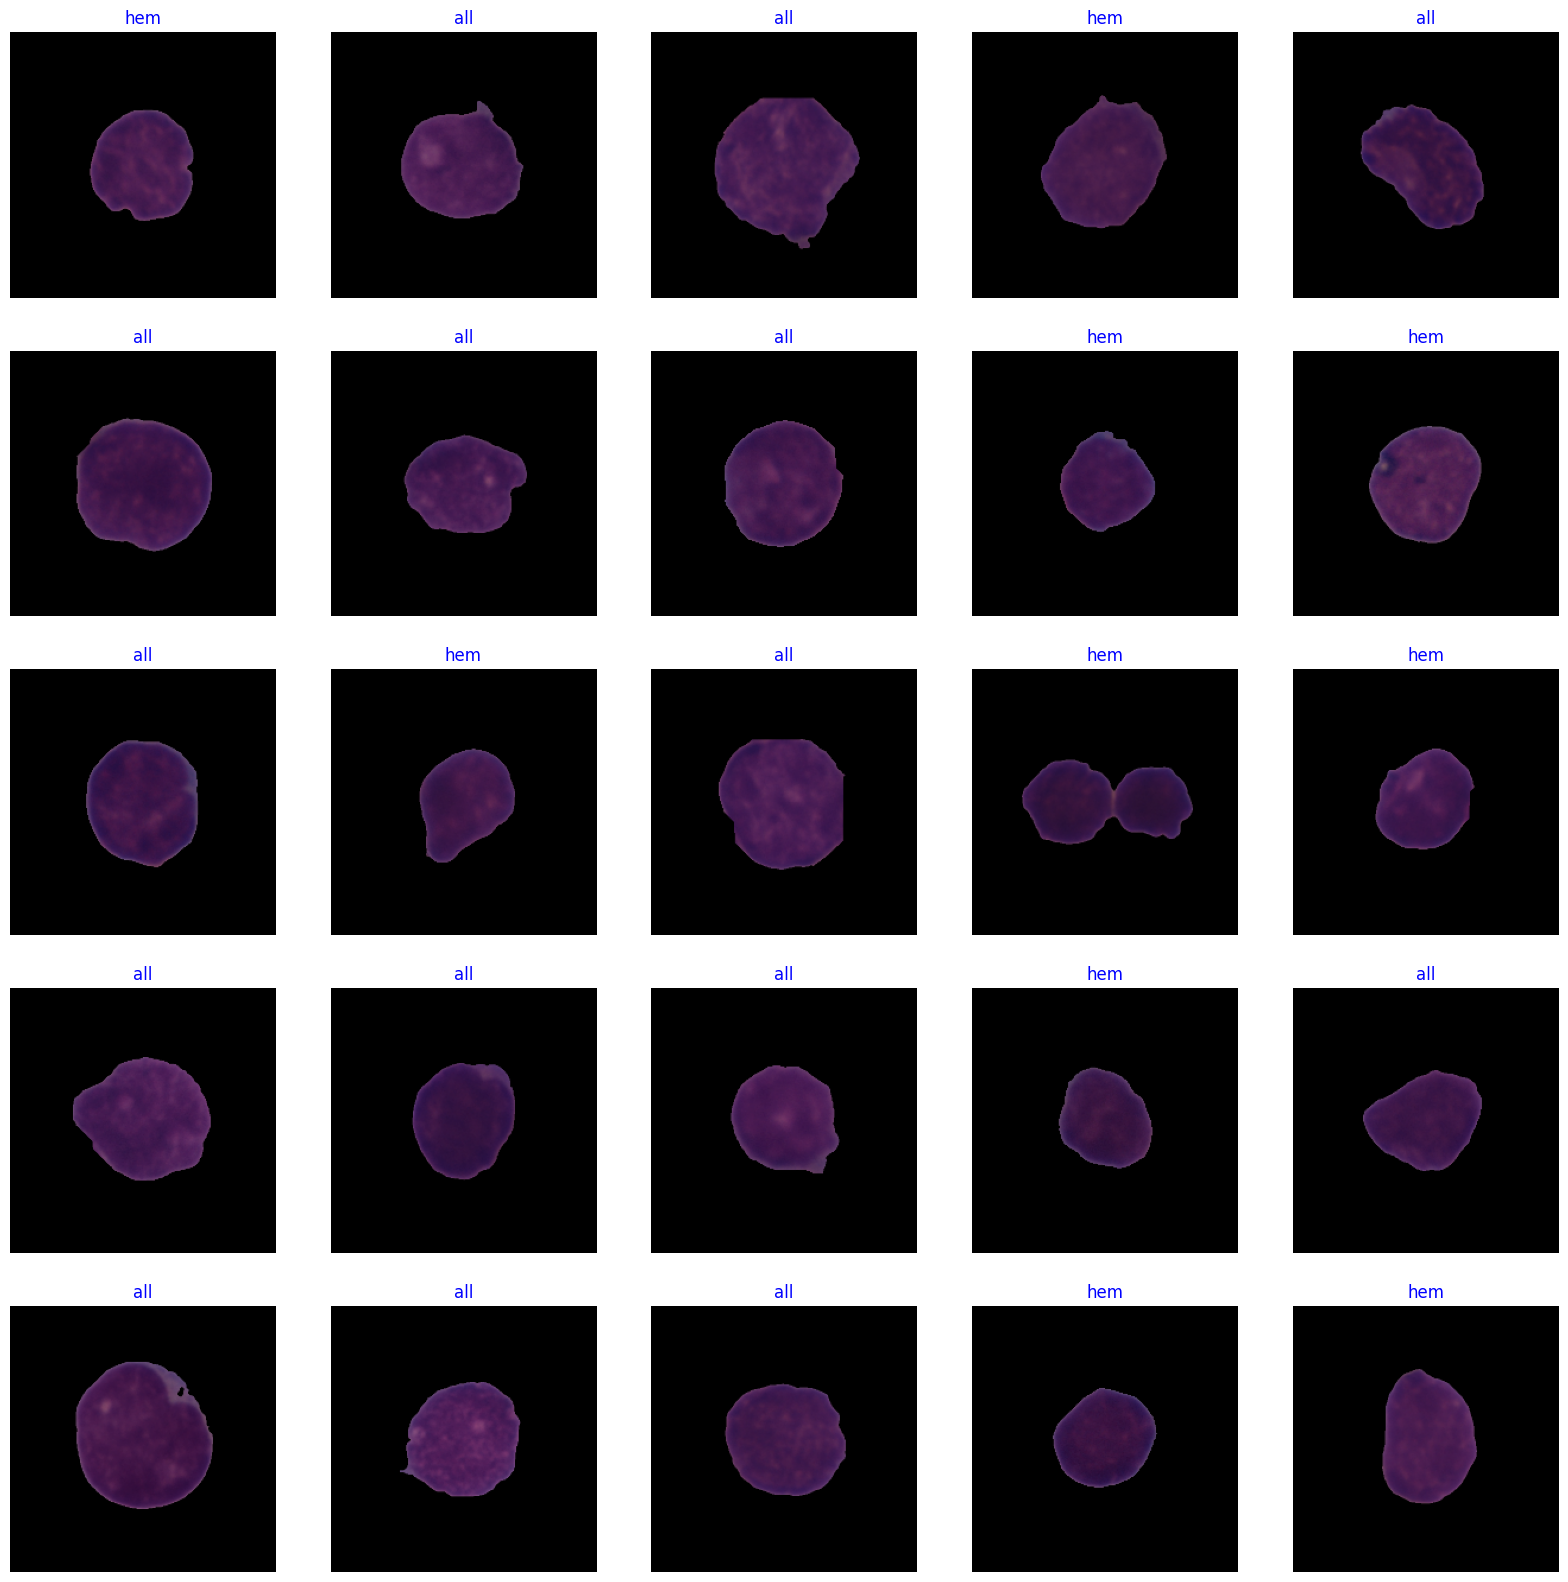

In [9]:
show_images(train_gen)

In [10]:
print(train_df.columns)


Index(['filepaths', 'labels'], dtype='object')


In [11]:
# Count the number of images belonging to each class
class_counts = train_df['labels'].value_counts()

# Display the counts
print("Class HEM:", class_counts[0])
print("Class ALL:", class_counts[1])



Class HEM: 5090
Class ALL: 2372


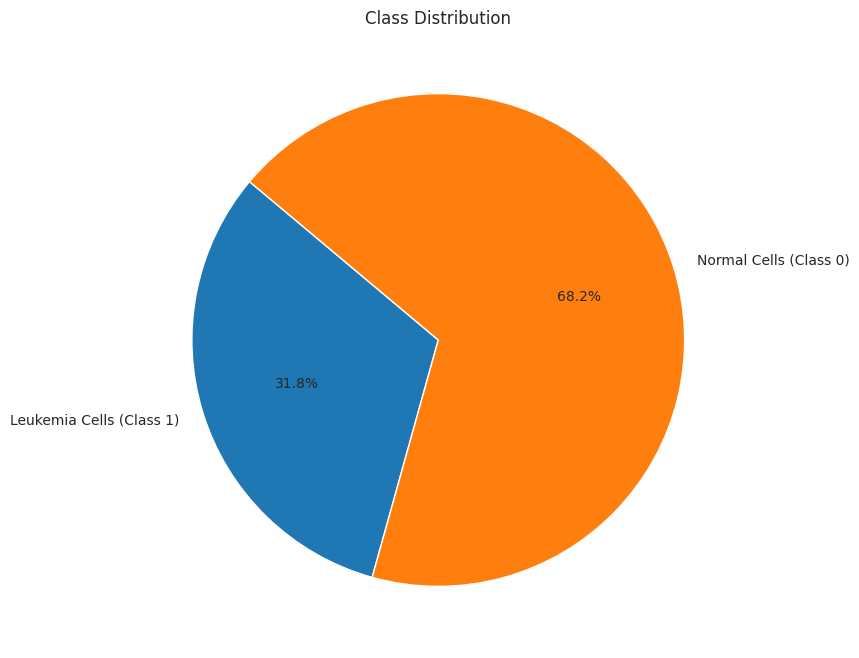

In [12]:
import matplotlib.pyplot as plt

# Count of class 1 (Leukemia)
class_1_count = class_counts[1]

# Plot the class distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie([class_1_count, len(train_df) - class_1_count], labels=['Leukemia Cells (Class 1)', 'Normal Cells (Class 0)'], autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()



#### **Generic Model Creation**

In [13]:
pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
from tqdm import tqdm

In [18]:
# from transformers import ViTForImageClassification, ViTFeatureExtractor
# # Define number of classes
# class_count = len(train_df['labels'].unique())  # Assuming 'train_df' is your training DataFrame
# # Define feature extractor and model
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# base_model = ViTForImageClassification.from_pretrained(
#     'google/vit-base-patch16-224',
#     num_labels=class_count,
#     ignore_mismatched_sizes=True
# )
# Prepare EfficientNet-B0 model
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [19]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, feature_extractor, img_size):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        self.img_size = img_size
        # Convert labels to integer
        self.dataframe['labels'] = self.dataframe['labels'].astype('category').cat.codes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']

        # Load image
        image = cv2.imread(img_path)
        image = cv2.resize(image, self.img_size)

        # Preprocess image
        inputs = self.feature_extractor(images=image, return_tensors='pt')
        pixel_values = inputs['pixel_values'].squeeze()

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.long)

        return pixel_values, label

In [20]:
# Define number of classes
class_count = len(train_df['labels'].unique())  # Assuming 'train_df' is your training DataFrame
img_size=(224,224)
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare datasets and dataloaders
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
train_dataset = CustomDataset(train_df, feature_extractor, img_size)
valid_dataset = CustomDataset(valid_df, feature_extractor, img_size)
test_dataset=CustomDataset(test_df, feature_extractor, img_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [22]:
epochs = 7
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

best_val_loss = float('inf')
best_model_weights = None
early_stop_counter = 0
patience = 3  # Number of epochs to wait before early stopping

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for pixel_values, labels in tqdm(train_loader):
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(pixel_values)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for pixel_values, labels in valid_loader:
            pixel_values, labels = pixel_values.to(device), labels.to(device)

            with autocast():
                outputs = model(pixel_values)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    val_loss /= len(valid_loader)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

    # Collect metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_model_weights = model.state_dict()
    #     early_stop_counter = 0
    # else:
    #     early_stop_counter += 1
    #     if early_stop_counter >= patience:
    #         print("Early stopping")
    #         break


100%|██████████| 187/187 [01:21<00:00,  2.30it/s]


Epoch 1/7
Train Loss: 0.3714 | Train Acc: 84.44%
Val Loss: 0.5241 | Val Acc: 79.42%


100%|██████████| 187/187 [00:54<00:00,  3.44it/s]


Epoch 2/7
Train Loss: 0.2369 | Train Acc: 90.61%
Val Loss: 0.4394 | Val Acc: 80.61%


100%|██████████| 187/187 [00:47<00:00,  3.98it/s]


Epoch 3/7
Train Loss: 0.1583 | Train Acc: 93.84%
Val Loss: 0.3678 | Val Acc: 88.99%


100%|██████████| 187/187 [00:48<00:00,  3.88it/s]


Epoch 4/7
Train Loss: 0.1202 | Train Acc: 95.31%
Val Loss: 0.2760 | Val Acc: 90.93%


100%|██████████| 187/187 [00:47<00:00,  3.96it/s]


Epoch 5/7
Train Loss: 0.0846 | Train Acc: 96.85%
Val Loss: 0.3070 | Val Acc: 91.31%


100%|██████████| 187/187 [00:48<00:00,  3.89it/s]


Epoch 6/7
Train Loss: 0.0679 | Train Acc: 97.55%
Val Loss: 0.3302 | Val Acc: 91.56%


100%|██████████| 187/187 [00:47<00:00,  3.97it/s]


Epoch 7/7
Train Loss: 0.0541 | Train Acc: 98.16%
Val Loss: 0.3984 | Val Acc: 90.81%


#### **Save model**

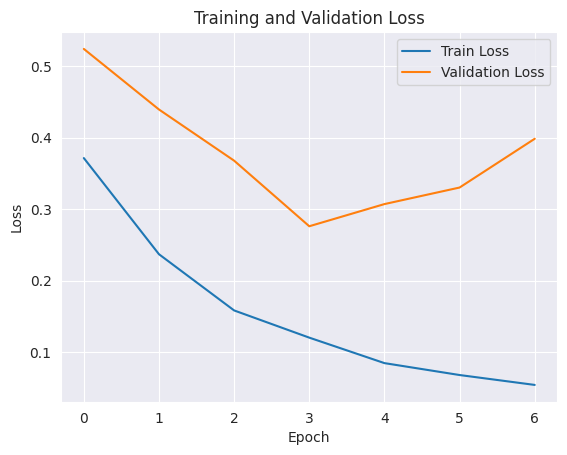

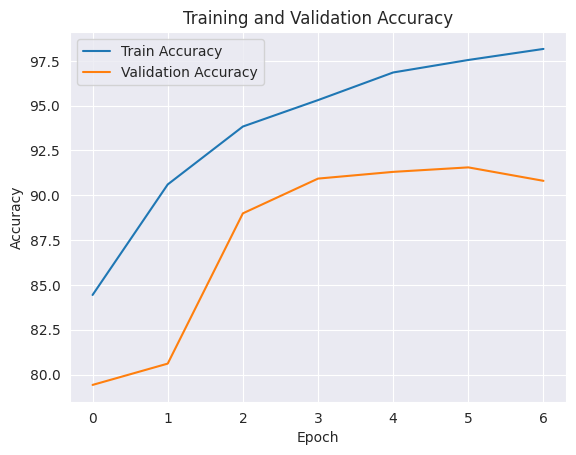

In [24]:

# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


# **Evaluate model**

In [25]:
# Set model to evaluation mode
model.eval()

# Define variables to store evaluation metrics
test_correct = 0
test_total = 0
test_loss = 0.0

# Criterion for calculating the loss
criterion = nn.CrossEntropyLoss()

# Iterate over the test dataset
with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item()

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Update evaluation metrics
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test loss
test_loss /= len(test_loader)

# Calculate accuracy
test_accuracy = 100. * test_correct / test_total

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4053 | Test Accuracy: 90.50%


#### **Display model performance**

Test Loss: 0.4053 | Test Accuracy: 90.50%


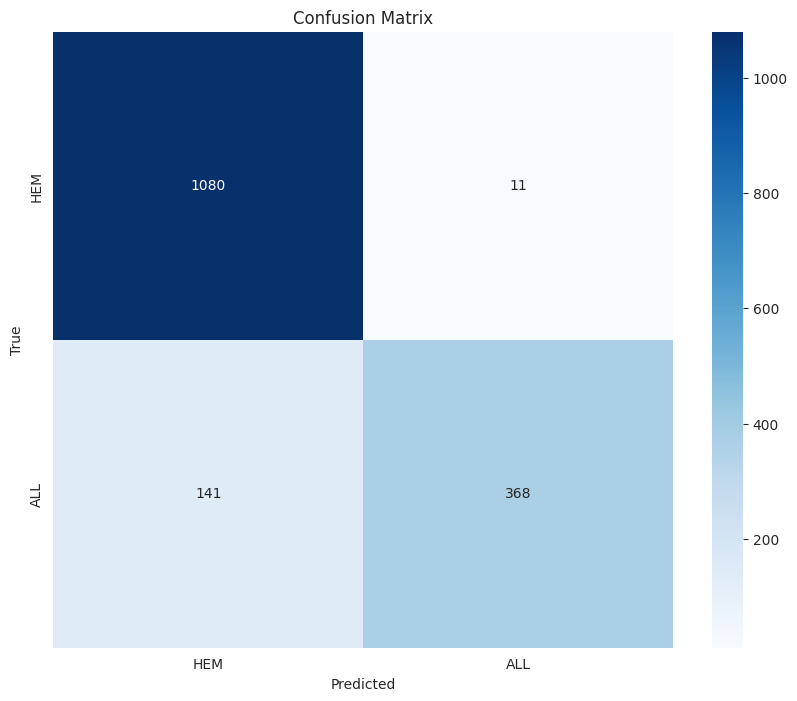

              precision    recall  f1-score   support

         HEM       0.88      0.99      0.93      1091
         ALL       0.97      0.72      0.83       509

    accuracy                           0.91      1600
   macro avg       0.93      0.86      0.88      1600
weighted avg       0.91      0.91      0.90      1600



In [26]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Define variables to store evaluation metrics
test_correct = 0
test_total = 0
test_loss = 0.0

# Criterion for calculating the loss
criterion = torch.nn.CrossEntropyLoss()

# Lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
with torch.no_grad():
    for pixel_values, labels in test_loader:
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # Forward pass
        outputs = model(pixel_values)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item()

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        # Update evaluation metrics
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

# Calculate test loss
test_loss /= len(test_loader)

# Calculate accuracy
test_accuracy = 100. * test_correct / test_total

# Print the test loss and accuracy
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%')

# Define class names
class_names = ['HEM', 'ALL']

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)
